## General properties
The following configuration properties may need to be changed:
- `instances_folder`: Folder where all instances of the problem are located.
- `output_folder`: Folder where instances chosen by this notebook to calibrate / set algorithms parameters will be copied. If the folder does not exist, it will be created.
- `percentage_preliminary_test`: Percentage of the total number of instances that will be included in the preliminary set.

In [45]:
percentage_preliminary_test = 0.15
instances_folder = "../instances/all"
output_folder = "../instances/benchmark"

## Algorithm and visualization properties

### PCA
The PCA method is used to reduce the number of dimensions. The fraction of variance explained by a principal component is the ratio between the variance of that principal component and the total variance.
Typically, we want the explained variance to be between 95–99%. **The chosen number of components will be the smallest one whose explained variance is greater than the configured value in `explained_pca_ratio`.**

### k-means

The instances will be groped using K-Means clustering. The implementation used is provided by `sklearn`. For more information, visit the [official web page](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In this section, general properties such as the color of the clusters or the initial configuration of the kmeans is determined:
- `init_kmeans`: How should the first point for each cluster be chosen.
    - `k-means++` : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.
    - `random`: choose n_clusters observations (rows) at random from data for the initial centroids.
- `random_state`: Determines random number generation seed for centroid initialization. Always configure a number in order to make it deterministic.
- `max_iter`: Maximum number of iterations of the k-means algorithm for a single run.
- `colors`: Colors used to represent the different clusters when drawing charts. See https://matplotlib.org/stable/gallery/color/named_colors.html por a complete colors reference.
- `max_n_cluster`: Maximum number of clusters to test. Instances will be grouped n clusters such as 1 <= n <= max_n_cluster

In [46]:
# PCA configuration
explained_pca_ratio = 0.90

# K-Means configuration
init_kmeans = 'k-means++'
random_state = 42
max_iter = 1000
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'brown', 'olive', 'gray', 'olive', 'crimson', 'teal']
max_n_cluster = 15

## Import the libraries

In [47]:
from os import listdir  # reading instances
from os.path import join  # reading instances
import shutil
import os

import networkx as nx  # manipulation, and study of the structure, dynamics, and functions of networks.

import math # math
import pandas as pd  # data manipulation and analysis
import numpy as np  # working with arrays and matrices
import itertools  # to perform some particular loops

from sklearn import preprocessing  # standardization  of data
from sklearn.decomposition import PCA  # principal component analysis
from sklearn.cluster import KMeans  # K-Means clustering
from sklearn.metrics import pairwise_distances  # Compute the distance matrix between two vectors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer # implements the “elbow” method to help data scientists select the optimal number of clusters by fitting the model with a range of values for K


import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library

%matplotlib inline

## Load Data: Reading instances

In [48]:
path = instances_folder
graphs = []
print("Reading files...")
for file in listdir(path):
    print("Reading file ", file)
    with open(join(path, file), 'r') as f:
        lines = f.readlines()
        lines = [l.replace('\t', ' ') for l in lines if len(l.strip().replace('\t', '')) != 0]
        num_vertices = int(lines[0])
        size = [int(x) for x in lines[1].split()]
        weights = []
        for v in range(num_vertices):
            weights.append([int(x) for x in lines[v + 2].split()])
        G = nx.Graph(name=file)
        for v in range(num_vertices):
            G.add_node(v, size=size[v])
        for i, j in itertools.product(range(num_vertices), range(num_vertices)):
            if weights[i][j] != 0:
                G.add_edge(i, j, weight=weights[i][j])
        nx.freeze(G)
        graphs.append(G)
print("Total instance read:", len(graphs))

Reading files...
Reading file  14a.txt
Reading file  14b.txt
Reading file  40-01.txt
Reading file  40-02.txt
Reading file  40-03.txt
Reading file  40-04.txt
Reading file  40-05.txt
Reading file  40-06.txt
Reading file  40-07.txt
Reading file  A60_01.txt
Reading file  A60_02.txt
Reading file  A60_03.txt
Reading file  A60_04.txt
Reading file  A60_05.txt
Reading file  A70_01.txt
Reading file  A70_02.txt
Reading file  A70_03.txt
Reading file  A70_04.txt
Reading file  A70_05.txt
Reading file  Am11a.txt
Reading file  Am11b.txt
Reading file  Am11c.txt
Reading file  Am11d.txt
Reading file  Am11e.txt
Reading file  Am11f.txt
Reading file  Am12a.txt
Reading file  Am12b.txt
Reading file  Am12c.txt
Reading file  Am12d.txt
Reading file  Am12e.txt
Reading file  Am12f.txt
Reading file  Am13a.txt
Reading file  Am13b.txt
Reading file  Am13c.txt
Reading file  Am13d.txt
Reading file  Am13e.txt
Reading file  Am13f.txt
Reading file  N30_01.txt
Reading file  N30_02.txt
Reading file  N30_03.txt
Reading file  

## Convert read instances into NetworkX Graphs

In [49]:
graph_id = []
num_vertices = []
num_edges = []
vertex_max_degree = []
vertex_min_degree = []
vertex_avg_degree = []
vertex_std_degree = []
is_regular = []
vertex_max_size = []
vertex_min_size = []
vertex_avg_size = []
vertex_std_size = []
edge_max_weight = []
edge_min_weight = []
edge_avg_weight = []
edge_std_weight = []
density = []
is_connected = []
components = []
for g in graphs:
    graph_id.append(g.graph.values())
    num_vertices.append(g.number_of_nodes())
    num_edges.append(g.number_of_edges())
    vertex_max_degree.append(max([int(val) for (_, val) in g.degree()]))
    vertex_min_degree.append(min([int(val) for (_, val) in g.degree()]))
    vertex_avg_degree.append(sum([int(val) for (_, val) in g.degree()]) / g.number_of_nodes())
    vertex_std_degree.append(np.std([int(val) for (_, val) in g.degree()]))
    is_regular.append(nx.is_regular(g))
    vertex_max_size.append(max(nx.get_node_attributes(g, "size").values()))
    vertex_min_size.append(min(nx.get_node_attributes(g, "size").values()))
    vertex_avg_size.append(sum(nx.get_node_attributes(g, "size").values()) / g.number_of_nodes())
    vertex_std_size.append(np.std(list(nx.get_node_attributes(g, "size").values())))
    edge_max_weight.append(max(nx.get_edge_attributes(g, "weight").values()))
    edge_min_weight.append(min(nx.get_edge_attributes(g, "weight").values()))
    edge_avg_weight.append(sum(nx.get_edge_attributes(g, "weight").values()) / g.number_of_edges())
    edge_std_weight.append(np.std(list(nx.get_edge_attributes(g, "weight").values())))
    density.append(nx.density(g))
    is_connected.append(nx.is_connected(g))
    components.append(nx.number_connected_components(g))

## Extract metrics of the graphs

In [50]:
data = {'id': graph_id,
        "num_vertices": num_vertices,
        "num_edges": num_edges,
        "vertex_max_degree": vertex_max_degree,
        "vertex_min_degree": vertex_min_degree,
        "vertex_avg_degree": vertex_avg_degree,
        "vertex_std_degree": vertex_std_degree,
        "vertex_max_size": vertex_max_size,
        "vertex_min_size": vertex_min_size,
        "vertex_avg_size": vertex_avg_size,
        "vertex_std_size": vertex_std_size,
        "edge_max_weight": edge_max_weight,
        "edge_min_weight": edge_min_weight,
        "edge_avg_weight": edge_avg_weight,
        "edge_std_weight": edge_std_weight,
        "density": density,
        "is_connected": is_connected,
        "components": components,
        "is_regular": is_regular
        }

df = pd.DataFrame(data)
df.head()

id  num_vertices  num_edges  vertex_max_degree  vertex_min_degree  \
0    (14a.txt)            14         69                 11                  9   
1    (14b.txt)            14         69                 11                  9   
2  (40-01.txt)            40        205                 16                  5   
3  (40-02.txt)            40        484                 30                 18   
4  (40-03.txt)            40        701                 39                 31   

   vertex_avg_degree  vertex_std_degree  vertex_max_size  vertex_min_size  \
0           9.857143           0.832993               20                3   
1           9.857143           0.832993               11                2   
2          10.250000           2.826217               15                5   
3          24.200000           2.758623               15                5   
4          35.050000           1.802082               15                5   

   vertex_avg_size  vertex_std_size  edge_max_weight  edge_min_weight  \
0         6.571429         4.370588               10                1   
1         5.714286         2.762726               10                1   
2        10.450000         3.049180               21                3   
3        10.100000         3.192178               21                3   
4         9.350000         3.431836               21                3   

   edge_avg_weight  edge_std_weight   density  is_connected  components  \
0         4.246377         2.715526  0.758242          True           1   
1         4.246377         2.715526  0.758242          True           1   
2        11.921951         5.555376  0.262821          True           1   
3        12.171488         5.514962  0.620513          True           1   
4        11.821683         5.461669  0.898718          True           1   

   is_regular  
0       False  
1       False  
2       False  
3       False  
4       False

## Understanding the metrics ¶

In [51]:
# Quick analysis of the data
df = df.drop(['id', 'is_regular', 'is_connected', 'components'], axis=1)
df.describe()

num_vertices    num_edges  vertex_max_degree  vertex_min_degree  \
count     53.000000    53.000000          53.000000          53.000000   
mean      31.603774   474.792453          26.094340          11.849057   
std       21.854712   575.130599          20.171633           9.286873   
min        9.000000    24.000000           7.000000           0.000000   
25%       12.000000    48.000000          10.000000           6.000000   
50%       30.000000   205.000000          16.000000           8.000000   
75%       56.000000   877.000000          46.000000          14.000000   
max       70.000000  2197.000000          69.000000          31.000000   

       vertex_avg_degree  vertex_std_degree  vertex_max_size  vertex_min_size  \
count          53.000000          53.000000        53.000000        53.000000   
mean           20.291307           3.565430        23.358491         2.698113   
std            15.433562           3.864297        21.182444         1.475243   
min             4.363636           0.000000         1.000000         1.000000   
25%             8.307692           1.263975        11.000000         1.000000   
50%            11.882353           1.802082        15.000000         3.000000   
75%            35.050000           3.260579        21.000000         3.000000   
max            62.771429          14.275396        71.000000         6.000000   

       vertex_avg_size  vertex_std_size  edge_max_weight  edge_min_weight  \
count        53.000000        53.000000        53.000000        53.000000   
mean         12.606496         6.253911        14.867925         1.264151   
std          11.023381         6.472681        17.857381         0.788156   
min           1.000000         0.000000         3.000000         1.000000   
25%           6.454545         2.558198         8.000000         1.000000   
50%           8.307692         3.192178        10.000000         1.000000   
75%          11.250000         5.810621        19.000000         1.000000   
max          40.385714        21.589874       100.000000         5.000000   

       edge_avg_weight  edge_std_weight    density  
count        53.000000        53.000000  53.000000  
mean          6.718743         3.891081   0.681917  
std           9.245325         5.308613   0.156826  
min           1.214286         0.444374   0.262821  
25%           3.354839         1.891134   0.607910  
50%           4.019793         2.657972   0.688961  
75%           8.142857         5.423073   0.769231  
max          50.636364        29.457491   1.000000

Text(0.5, 1.0, 'Correlation between different features')

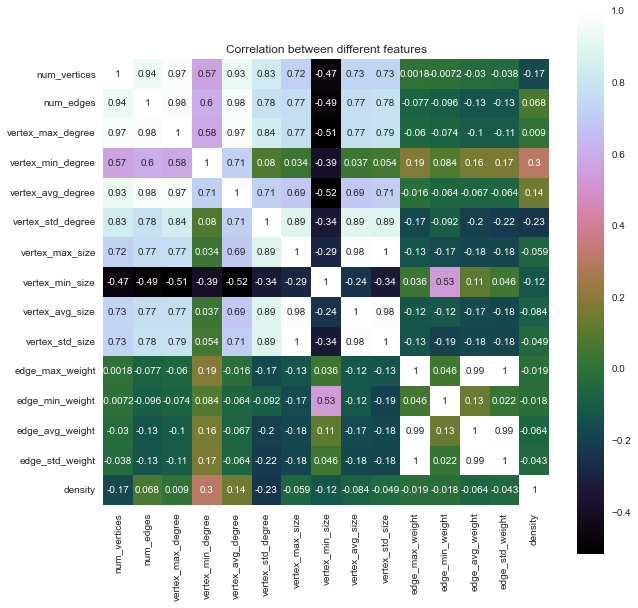

In [52]:
correlation = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

plt.title('Correlation between different features')

## Metrics standardization

In [53]:
data_scaled = pd.DataFrame(preprocessing.scale(df), columns=df.columns)
data_scaled.head()

num_vertices  num_edges  vertex_max_degree  vertex_min_degree  \
0     -0.813199  -0.712318          -0.755456          -0.309719   
1     -0.813199  -0.712318          -0.755456          -0.309719   
2      0.387860  -0.473587          -0.505211          -0.744556   
3      0.387860   0.016163           0.195474           0.668665   
4      0.387860   0.397079           0.645915           2.081886   

   vertex_avg_degree  vertex_std_degree  vertex_max_size  vertex_min_size  \
0          -0.682539          -0.713865        -0.160068         0.206594   
1          -0.682539          -0.713865        -0.589014        -0.477748   
2          -0.656841          -0.193124        -0.398371         1.575276   
3           0.255683          -0.210783        -0.398371         1.575276   
4           0.965424          -0.460685        -0.398371         1.575276   

   vertex_avg_size  vertex_std_size  edge_max_weight  edge_min_weight  \
0        -0.552718        -0.293749        -0.275209        -0.338358   
1        -0.631219        -0.544534        -0.275209        -0.338358   
2        -0.197501        -0.499855         0.346678         2.223494   
3        -0.229556        -0.477551         0.346678         2.223494   
4        -0.298244        -0.440170         0.346678         2.223494   

   edge_avg_weight  edge_std_weight   density  
0        -0.269977        -0.223562  0.491346  
1        -0.269977        -0.223562  0.491346  
2         0.568179         0.316509 -2.697944  
3         0.595428         0.308823 -0.395288  
4         0.557230         0.298688  1.395666

## Principal component analysis (PCA)
Principal component analysis (PCA) is the process of computing the principal components and using them to perform a change of basis on the data.
To perform the PCA we first determine the numer of principal components.


Text(0, 0.5, 'Cumulative explained variance')

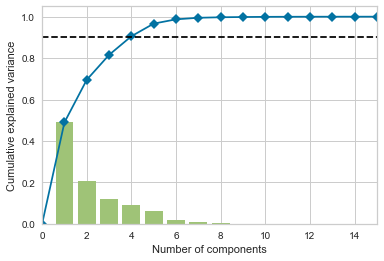

In [54]:
pca = PCA().fit(data_scaled)
line_data = np.cumsum(pca.explained_variance_ratio_)
line_data = np.insert(line_data, 0, 0)
plt.bar(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='g')
plt.plot(np.arange(0, len(line_data)), line_data, marker='D')
plt.xlim(0, len(pca.explained_variance_ratio_), 1)
plt.axhline(y=explained_pca_ratio, color='black', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [55]:
sklearn_pca = PCA(n_components=explained_pca_ratio)
data = sklearn_pca.fit_transform(data_scaled)

## Choosing the number of clusters: Elbow Method
The elbow method is used to determine the number of clusters in a data set.
The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

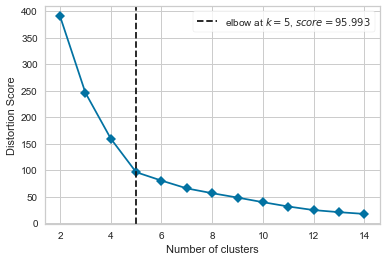

In [56]:
model = KMeans(init=init_kmeans, random_state=random_state, max_iter=max_iter)

visualizer = KElbowVisualizer(model, k=(2, max_n_cluster), timings=False)
visualizer.fit(data)  # Fit the data to the visualizer
visualizer.finalize()
visualizer.ax.set_title("")
visualizer.ax.set_ylabel("Distortion Score")
visualizer.ax.set_xlabel("Number of clusters")
plt.show()

## Compute K-Means Clustering

In [ ]:
n_cluster = visualizer.elbow_value_
kmeans = KMeans(n_clusters=n_cluster, init=init_kmeans, random_state=random_state, max_iter=max_iter).fit(data)
labels = kmeans.predict(data)

## Silhouette Analysis
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

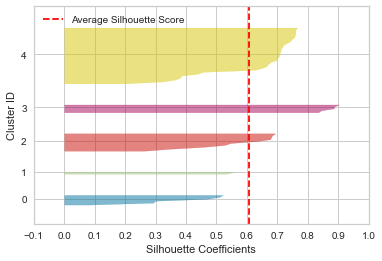

In [71]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(data)  # Fit the data to the visualizer
visualizer.finalize()
visualizer.ax.set_title("")
visualizer.ax.set_ylabel("Cluster ID")
visualizer.ax.set_xlabel("Silhouette Coefficients")
plt.show()

## Cluster visualization

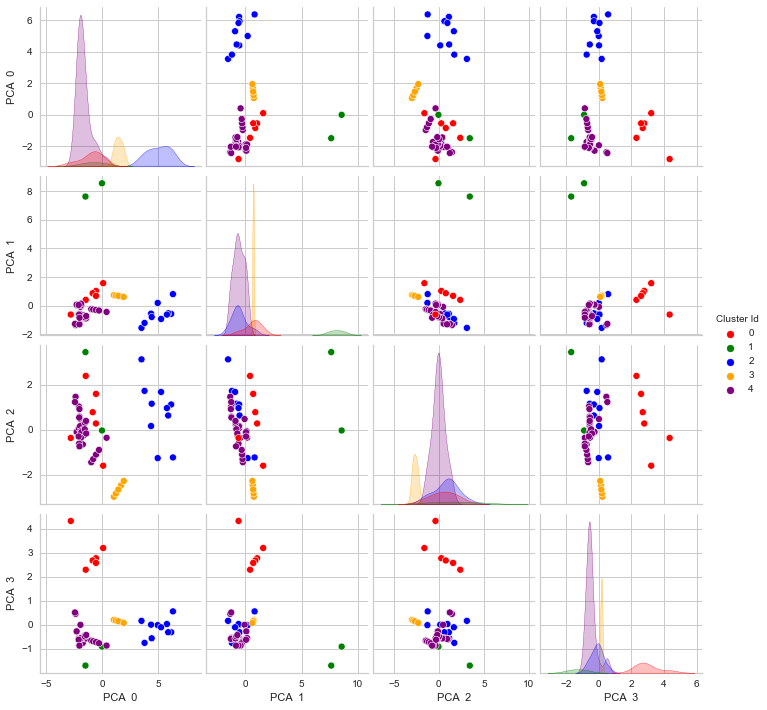

In [75]:
color_dict = dict()
for index, value in enumerate(colors):
    color_dict[index] = value

result = {"Cluster Id": labels}
for i in range(data.shape[1]):
    result["PCA  " + str(i)] = data[:, i]

testdf = pd.DataFrame(result)
sns.pairplot(testdf, hue="Cluster Id", palette=color_dict)

## Visualization of the graphs

Nodes coloured according to the cluster they belong to.

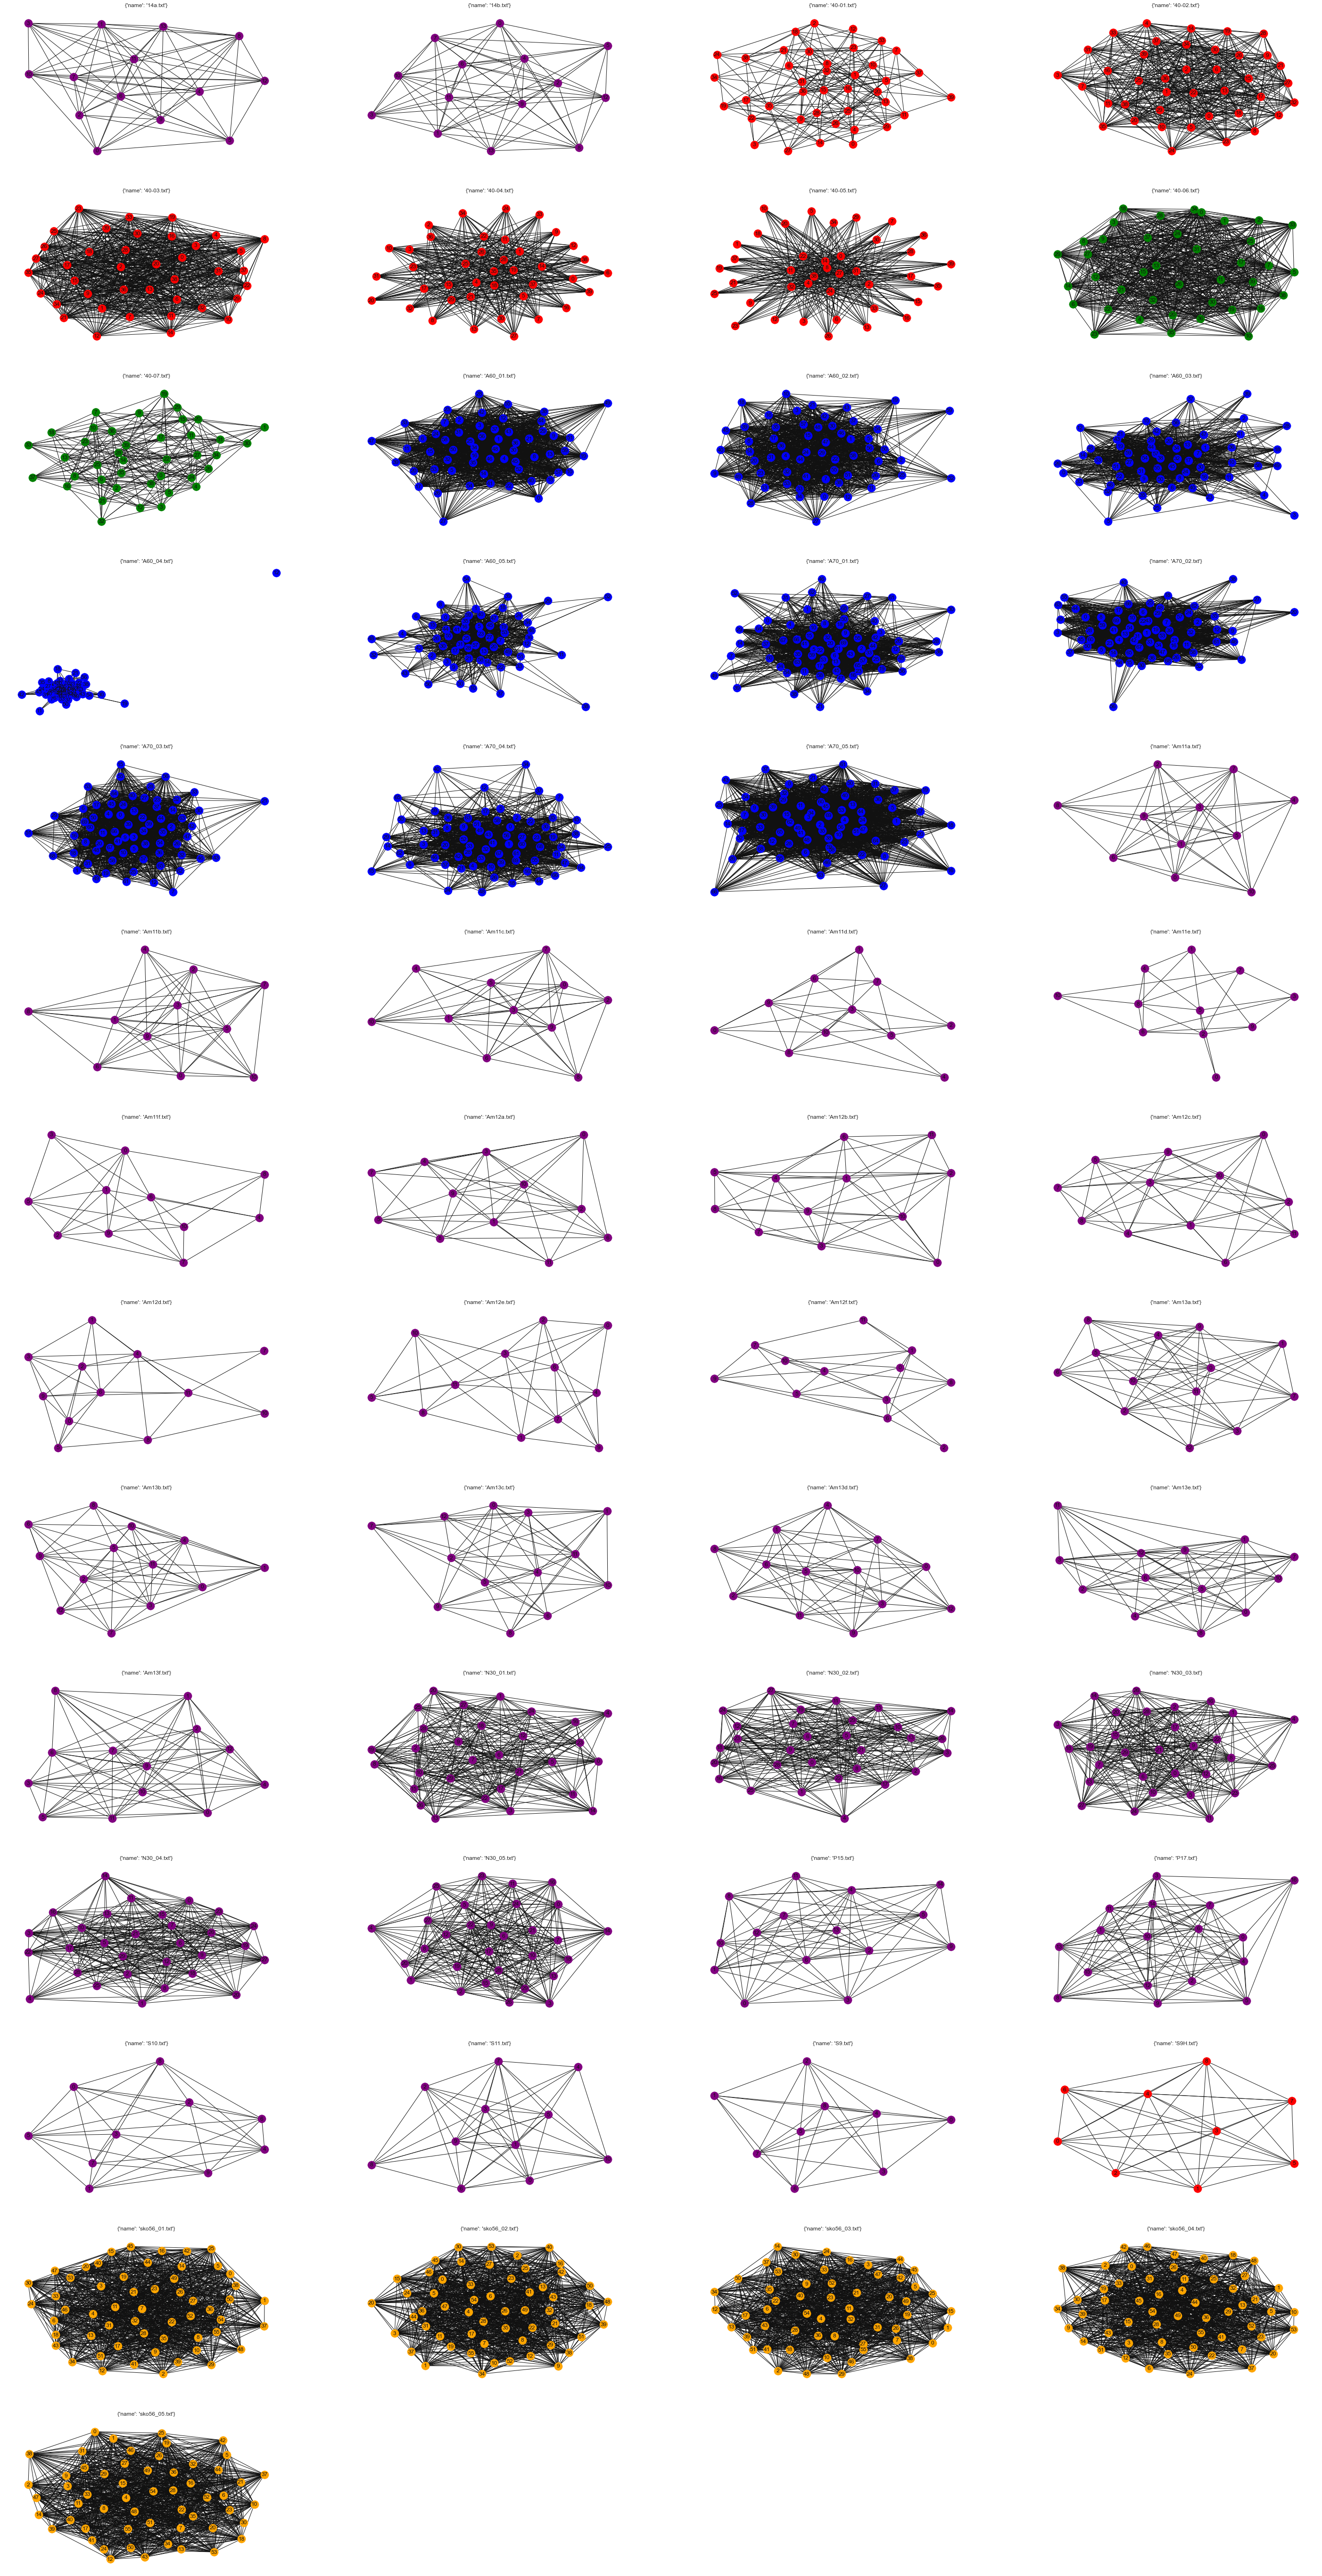

In [61]:
i = 1
plt.figure(figsize=(50, 100))
for g in graphs:
    plt.subplot(math.ceil(len(graphs) / 4), 4, i)
    plt.axis("off")
    plt.title(g.graph)
    nx.draw(g, node_color=colors[labels[i - 1]], with_labels=True)
    i = i + 1

## Instance selection
### Centroids

In [62]:
distances = pairwise_distances(kmeans.cluster_centers_, data)
distancesToCentroid = []
i = 0
for c in labels:
    distancesToCentroid.append(distances[c][i])
    i += 1

In [63]:
clusters = {}
clusters["ClusterId"] = labels
clusters["Instance"] = [g.graph['name'] for g in graphs]
clusters['Distances'] = distancesToCentroid
cluster_df = pd.DataFrame(clusters)

cluster_df.head()

ClusterId   Instance  Distances
0          4    14a.txt   0.247526
1          4    14b.txt   0.669275
2          0  40-01.txt   2.061261
3          0  40-02.txt   0.677040
4          0  40-03.txt   2.566389

In [64]:
sorted_df = []

for k in range(n_cluster):
    dfk = cluster_df.loc[cluster_df['ClusterId'] == k]
    sorted_df.append(dfk.sort_values(by='Distances', ascending=True).to_numpy())

# Sort by cluster size
sorted_df.sort(key=lambda x: -len(x))

sorted_df

[array([[4, 'Am13a.txt', 0.24311891276770004],
        [4, '14a.txt', 0.2475262010843366],
        [4, 'P15.txt', 0.2529575525841043],
        [4, 'P17.txt', 0.32176090893904186],
        [4, 'Am12c.txt', 0.3612706321114903],
        [4, 'Am12a.txt', 0.3964969994106706],
        [4, 'Am12b.txt', 0.42513751317356435],
        [4, 'Am13b.txt', 0.46968379881385847],
        [4, 'Am13c.txt', 0.5726349320974601],
        [4, '14b.txt', 0.6692752428637292],
        [4, 'Am13e.txt', 0.6757238595387758],
        [4, 'Am13d.txt', 0.7259593815431611],
        [4, 'S10.txt', 0.7877181086016725],
        [4, 'S11.txt', 0.8292279364923322],
        [4, 'Am13f.txt', 0.8381345154850374],
        [4, 'Am11b.txt', 0.8986537229804911],
        [4, 'S9.txt', 0.8996434541042516],
        [4, 'Am11a.txt', 0.9214355540058539],
        [4, 'Am11c.txt', 0.9383194214921756],
        [4, 'Am11f.txt', 0.9523775779168813],
        [4, 'Am11d.txt', 0.971438578924752],
        [4, 'Am12f.txt', 1.2396830515520811],


In [65]:
instance_remaining = math.ceil(percentage_preliminary_test * len(labels))
preliminary_instances = []
aux = [i for i in sorted_df.copy()]

stopAt = instance_remaining
takeFromCluster = 0
while takeFromCluster < stopAt:
    cluster = aux[takeFromCluster % len(aux)]
    if len(cluster) == 0:
        stopAt += 1
    else:
        instance = cluster[0][1]
        preliminary_instances.append(instance)
        aux[takeFromCluster % len(aux)] = np.delete(cluster, 0, 0)

    takeFromCluster += 1

In [66]:
n_preliminar_instances = math.ceil(percentage_preliminary_test * len(labels))
print(f"""
SUMMARY:
 - Total instances {len(labels)}
 - Preliminary %: {percentage_preliminary_test}
 - Number of preliminary instances: {n_preliminar_instances}
 - Instance selected: {preliminary_instances}
""")


SUMMARY:
 - Total instances 53
 - Preliminary %: 0.15
 - Number of preliminary instances: 8
 - Instance selected: ['Am13a.txt', 'A70_03.txt', '40-04.txt', 'sko56_04.txt', '40-06.txt', '14a.txt', 'A60_03.txt', '40-02.txt']



In [67]:
shutil.rmtree(output_folder, ignore_errors=True)
os.mkdir(output_folder)
for preliminar_instance in preliminary_instances:
    src = instances_folder + "/" + preliminar_instance
    dst = output_folder + "/" + preliminar_instance
    shutil.copyfile(src, dst)

print('Preliminary instance have been copied to ', output_folder)

Preliminary instance have been copied to  ../instances/benchmark
